In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
import enum
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from os import listdir
from os.path import isfile, join
import numpy as np
from numpy.linalg import svd, norm
from numpy import dot
import os
import pickle
import math
import re
import pandas as pd
import time

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
# tiền xử lý text
def preprocess_text(text):
    processed_text = text.lower()
    processed_text = processed_text.replace("’", "'")
    processed_text = processed_text.replace("“", '"')
    processed_text = processed_text.replace("”", '"')
    # loại bỏ các ký tự đặc biệt và chữ số
    # chỉ giữ lại các kí tự alphabet
    non_words = re.compile(r"[^A-Za-z']+")
    processed_text = re.sub(non_words, ' ', processed_text)
    return processed_text

# input một text (một câu hoặc một đoạn văn bản)
# output list các từ (term) trong văn bản sau khi process
def get_words_from_text(text):
    # loại bỏ chữ số và các ký tự đặc biệt trong text
    processed_text = preprocess_text(text)
    # loại bỏ stopword
    filtered_words = [word for word in processed_text.split() if word not in stopwords.words('english')]
    processed_words = []
    for i in range(len(filtered_words)):
        # thực hiện lemmatize
        # ex: am, is, are -> be
        processed_words.append(lemmatizer.lemmatize(filtered_words[i]))
    return processed_words

# đọc file và trả về nội dung của file dưới dạng chuỗi
def get_text_from_file(filename):
    with open(filename, encoding='utf-8', mode='r') as f:
        text = f.read()
    return text

# lập chỉ mục
def indexing(docs_path):
    # terms lưu danh sách các term
    # index lưu chỉ số của doc
    # Vd: terms = ['hello', 'bye']
    #     index = [[(1,5), (2,10)], [(3, 1)]] -> posting list
    # -> 'hello' xuất hiện trong doc 1 5 lần, xuất hiện trong doc 2 10 lần
    terms = []
    index = []
    norm_list = []
    N = 0

    # Indexing postings
    # đếm term trên từng doc theo thứ tự chỉ số tăng dần
    for doc_file in sorted(os.listdir(docs_path),key=lambda x: int(os.path.splitext(x)[0])): # tách thứ tự của doc từ tên doc
        filename = os.path.join(docs_path, doc_file)
        N += 1

        #đọc text từ file
        text = get_text_from_file(filename)
        # words lưu các term sau khi process (bỏ stopword, ký tự đặc biệt, lemmatize,...)
        words = get_words_from_text(text)

        for word in words:
            # nếu một term chưa được ghi lại trong list term thì thêm term đó vào list
            if word not in terms:
                terms.append(word)
                index.append([(N, 1)])
            # term đã được ghi lại trước đó
            else:
                #  lấy ra index của term trong list terms
                temp_index = terms.index(word)

                # index[temp_index] -> posting list của term ở index temp_index
                # i[0] -> số thứ tự của doc
                # i[1] -> term frequency
                # nếu doc thứ N chưa được ghi lại lần nào thì thêm doc N vào posting list với term frequency là 1
                if N not in [i[0] for i in index[temp_index]]:
                    index[temp_index].append((N, 1))
                    continue
                # nếu N đã được ghi lại thì tăng term frequency của N thêm 1
                # lặp qua từng posting trong posting list để tìm doc N
                for i in range(len(index[temp_index])):
                    if index[temp_index][i][0] == N:
                        index[temp_index][i] = (N, index[temp_index][i][1] + 1)
                        break

    # Calculate weights
    # thay vì lưu tf (term frequency) trong posting list thì lưu tf * idf (inversed document frequency)
    for i in range(len(index)):
        for j in range(len(index[i])):
            # temp -> (document index, term frequency)
            temp = list(index[i][j])
            # len(index[i]) -> document frequency của term thứ i
            # lưu lại weight mới vào temp[1]
            temp[1] = index[i][j][1] * math.log(N/len(index[i])) # Formula: TF * IDF (IDF = log(N / ndoc(t)))
            # chuyển kiểu dữ liệu trở lại thành tuple
            index[i][j] = tuple(temp)

    # Normalization
    # norm list lưu độ dài của các vector document
    for i in range(N):
        norm = 0
        for j in range(len(index)):
            # temp lưu weight của các term trong doc
            temp = [item for item in index[j] if item[0] == i+1]
            # tính norm của document vector
            # norm thực chất là độ dài cảu document vector
            if len(temp) != 0:
                norm += math.pow(temp[0][1], 2)
        norm_list.append(math.sqrt(norm))
    # normalize documnet vector
    for i in range(len(index)):
        for j in range(len(index[i])):
            temp = list(index[i][j])
            temp[1] = index[i][j][1] / norm_list[index[i][j][0]-1]
            index[i][j] = tuple(temp)

    return terms, index

In [ ]:
terms, index = indexing(r'/content/drive/MyDrive/CS419/Dataset/Cranfield/docs') # lập chỉ mục

In [ ]:
print(len(terms))

6291


In [ ]:
print(index[:2])

[[(1, 0.06967927830310736), (11, 0.04895005974394764), (12, 0.03971875576770193), (17, 0.04272563222391129), (19, 0.07969671734744659), (25, 0.024972104221465452), (29, 0.02897793923681581), (30, 0.04588187338889109), (35, 0.04726191918734976), (41, 0.06786968844786007), (42, 0.01777561811106737), (47, 0.029680774223145776), (52, 0.039783982685437216), (53, 0.0294943704314764), (58, 0.03801162712658475), (69, 0.042732895301518206), (70, 0.02649292715325675), (74, 0.06898956040221096), (78, 0.028645027450492327), (84, 0.08267570458612562), (99, 0.046625758631334634), (101, 0.024147855384005778), (103, 0.03446541687127354), (112, 0.036738130327911116), (115, 0.03053406087056303), (121, 0.045739071791121334), (123, 0.06320001685643514), (137, 0.08373431561588596), (140, 0.019224415898435633), (142, 0.0573680366244685), (154, 0.056048996913241986), (156, 0.018497237261408304), (168, 0.02318295387866382), (170, 0.029214288345885353), (171, 0.04512750063420537), (173, 0.04010918755204746), (

In [ ]:
def tokenizeFile(fld):
    # fld là đường link đến một folder

    dic = {} # lưu tên file
    file = {} # lưu số lượng mỗi term trong doc
    i = 0
    # loop qua từng file trong folder đó
    for f in listdir(fld):
        # f là tên của file
        # fname là đường link dẫn đến file f
        fname = join(fld, f)
        if isfile(fname):
            dic[i] = f
            r = open(fname, 'rt', encoding='utf-8')
            terms = {}
            for s in r:
                # sents lưu danh sách các câu trong file
                sents = sent_tokenize(s.strip())
                for sent in sents:

                    # lưu danh sách các từ trong một câu
                    words = word_tokenize(sent)

                    for word in words:
                        # loại bỏ chữ số
                        if not word.isalnum():
                            continue
                        # loại bỏ các từ trong danh sách stop words
                        if word in stop_words:
                            continue
                        # lemmatize
                        word = lemmatizer.lemmatize(word)
                        # đếm số lượng term trong doc
                        if terms.get(word) == None:
                            terms[word] = 1
                        else:
                            terms[word] += 1
            # lưu số lượng của mỗi term trong doc
            file[i] = terms
            i += 1
    return dic, file

In [ ]:
# hàm trả về n term xuất hiện nhiều nhất trong collection
def selectTerms(files, n):
    # đếm tổng số term trên toàn collection
    terms = {}
    for ind in files:
        file = files[ind]
        for term in file:
            if terms.get(term) == None:
                terms[term] = file[term]
            else:
                terms[term] += file[term]

    # sắp xếp term theo độ phổ biến của term (độ phổ biến giảm dần) - ý là term nào nhiều hơn thì xếp trước
    sortterms = sorted(terms.items(), key = lambda item: item[1], reverse=True)
    # lấy n term có độ phổ biến lớn nhất
    sortterms = sortterms[:n]
    # res chỉ chứa các term phổ biến trong khi sortterms có chứa cả số lần xuất hiện của term trong collection
    res = [w for w, i in sortterms]
    return res

In [ ]:
# tạo ma trận term-document
def toMatrix(files, terms):
    M = []
    n = len(files)
    for i in range(len(terms)):
        row = [0] * n
        M.append(row)
    for c in files:
        for term in files[c]:
            try:
                r = terms.index(term)
                M[r][c] += files[c][term]
            except:
                continue
    return M

In [ ]:
def lsi(S, Sig, Ut, dim):
    # chỉ lấy dim singular value lớn nhất
    Z = np.zeros((len(S), len(Ut)))
    for i, value in enumerate(Sig):
      Z[i][i] = value
    Z = Z[:dim, :dim]
    S = S[:,:dim]
    Ut = Ut[:dim,:]

    # D là ma trận Ut sau khi giảm còn dim chiều
    D = np.matmul(Z, Ut)
    # mỗi hàng trong D là vector đại diện cho một document
    D = np.transpose(D)

    return D, Z, S

In [ ]:
def indexBoolean(fld, filedic):
    # filedic là một dictionary với key là số thứ tự của file, value là tên file
    ind = {}
    for i, f in filedic.items():
        fname = join(fld, f)
        if isfile(fname):
            r = open(fname, 'rt', encoding='utf-8')
            # loop qua từng dòng trong file
            for s in r:
                # tách riêng từ câu
                sents = sent_tokenize(s.strip())
                for sent in sents:
                    # tách riêng từng từ
                    words = word_tokenize(sent)
                    for word in words:
                        # preprocess các từ để được term
                        if not word.isalnum():
                            continue
                        if word in stop_words:
                            continue

                        word = lemmatizer.lemmatize(word)

                        # lập chỉ mục ngược
                        if ind.get(word) == None:
                            ind[word] = [i]
                        else:
                            ind[word].append(i)
            r.close()
    return ind

In [ ]:
def searchBoolean(ind, qry): # hàm trả về các document chứa các term xuất hiện trong query
    ret = []
    terms = []

    # xử lý query tương tự như xử lý document
    words = word_tokenize(qry)
    for word in words:
        if not word.isalnum():
            continue
        if word in stop_words:
            continue

        word = lemmatizer.lemmatize(word)
        terms.append(word)

    return terms


def reranking(D, terms, qry, Ut, Z, terms_ind_dict):
    q = None
    # lấy ra từ ma trận K các vector của các term xuất hiện trong query
    # q là tổng của các vector đó
    q = np.zeros(len(terms))
    for term in qry:
        if term in terms:
            i = terms_ind_dict[term]
            q[i] += 1
    q = np.linalg.inv(Z).dot(Ut.T).dot(q)

    dlist = {}

    similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
    dlist = pd.DataFrame(similarity, index=range(1400), columns=None).sort_values(by=0, ascending=False)

    res = dlist.index
    return list(res)

def get_text_from_file(filename):
    with open(filename, encoding='UTF-8', mode='r') as f:
        text = f.read()
    return text

def calculate_precision_recall(input_query_path, input_query_res_file, D, Ut, Z, terms_inx_dict):
    precision_list = []
    recall_list = []

    res_gold_list = {}
    for res_file in os.listdir(input_query_res_file):
        filename = os.path.join(input_query_res_file, res_file)
        # Tách kết quả truy xuất từ file có sẵn
        res_gold_list[res_file] = set(get_text_from_file(filename=filename).split())

    res_only_list = {}
    for query_file in os.listdir(input_query_path):
        filename = os.path.join(input_query_path, query_file)
        qry = searchBoolean(index, get_text_from_file(filename=filename))
        # Truy xuất kết quả theo query
        res = reranking(D, terms, qry, Ut, Z, terms_inx_dict)
        for idx, i in enumerate(res):
            # Tách số thứ tự từ tên file
            res[idx] = dic[res[idx]][:-4]
        # Kết quả trả về của từng query
        res_only_list[query_file] = set(res)

    for idx, i in enumerate(res_only_list):
        try:
            # Tính TP, FP, FN cho mỗi query
            true_positives = res_only_list[i].intersection(res_gold_list[i])
            false_positives = res_only_list[i].difference(res_gold_list[i])
            false_negatives = res_gold_list[i].difference(res_only_list[i])

            # Tính Precision và Recall cho mỗi query
            precision = len(true_positives) / (len(true_positives) + len(false_positives))
            recall = len(true_positives) / (len(true_positives) + len(false_negatives))

            precision_list.append(precision)
            recall_list.append(recall)
        except:
            pass

    return precision_list, recall_list


def calculate_AP(res_only, res_gold):
    # AP (average precision) cho một query
    # AP chỉ được tính tại những điểm retrive được relevant document
    precision = 0   # đây là biến đếm, không precision thực sự
    precision_list = []
    recall_list = []

    for idx, i in enumerate(res_only):
        if i in res_gold:
            # với mỗi relevant document retrive được thì tăng precision thêm 1
            precision += 1
            # tính precision, recall và thêm vào precision_list, recall_list
            precision_list.append(float(precision)/(idx+1))
            recall_list.append(float(precision)/len(res_gold))

    temp = 0
    # tính AP nội suy
    for i in range(len(precision_list)-1, -1, -1):
        if temp >= precision_list[i]:
            precision_list[i] = temp
        elif temp < precision_list[i]:
            temp = precision_list[i]

    # tính MAP 11 điểm
    # chỉ tính tại cái vị trí có recall nằm trong list points
    precision_list_11 = []
    points = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for idx, i in enumerate(points):
        for j in range(len(recall_list)):
            if recall_list[j] >= i:
                precision_list_11.append(max(precision_list[j:]))
                break

    if len(precision_list_11) < 11:
        precision_list_11 += [0]*(11-len(precision_list_11))

    average_precision = sum(precision_list_11)/len(precision_list_11)
    return average_precision


def calculate_MAP(input_query_path,input_query_res_file, D, Ut, Z, terms_inx_dict):

    AP_list = []

    res_gold_list = {}
    for res_file in os.listdir(input_query_res_file):
        filename = os.path.join(input_query_res_file, res_file)
        # tách kết quả truy xuất từ file có sẵn
        res_gold_list[res_file] = get_text_from_file(filename=filename).split()

    res_only_list = {}
    for query_file in os.listdir(input_query_path):
        filename = os.path.join(input_query_path, query_file)
        qry = searchBoolean(index, get_text_from_file(filename=filename))
        # truy xuất kết quả theo query
        res = reranking(D, terms, qry, Ut, Z, terms_inx_dict)
        for idx, i in enumerate(res):
            # tách số thứ tự từ tên file
            res[idx] = dic[res[idx]][:-4]
        # kết quả trả về của từng query
        res_only_list[query_file] = res

    # tính AP cho mỗi query
    for idx, i in enumerate(res_only_list):
        try:
            AP_list.append(calculate_AP(res_only_list[i],res_gold_list[i]))
        except:pass

    return sum(AP_list)/len(AP_list)  # trả về MAP

In [ ]:
CORPUS = r'/content/drive/MyDrive/CS419/Dataset/Cranfield/docs'
dic, files = tokenizeFile(CORPUS)
index = indexBoolean(CORPUS, dic)
input_query_path_corpus = r'/content/drive/MyDrive/CS419/Dataset/Cranfield/queries'
input_query_res_file_corpus = r'/content/drive/MyDrive/CS419/Dataset/Cranfield/qrel'
terms = selectTerms(files, len(terms))

In [ ]:
terms_inx_dict = {term : 0 for term in terms}
for i in range(len(terms)):
  terms_inx_dict[terms[i]] = i

A = toMatrix(files, terms)
S_full, Sig, Ut_full = svd(A)

In [ ]:
k = []
map = []
pre_recall = []
running_time = []

for var in range(100,500,10):
  k.append(var)
  D, Z, S = lsi(S_full, Sig, Ut_full, var)
  start_time = time.time()
  temp0 = calculate_precision_recall(input_query_path_corpus,input_query_res_file_corpus, D, S, Z, terms_inx_dict)
  pre_recall.append(temp0)
  temp = calculate_MAP(input_query_path_corpus,input_query_res_file_corpus,D, S, Z, terms_inx_dict)
  map.append(temp)
  print(var)
  end = time.time() - start_time
  running_time.append(end)
  print("--- %s seconds ---" % (end))
  print(temp)

<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
 

100
--- 12.833253145217896 seconds ---
0.2783084190754291


<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
 

110
--- 10.169848680496216 seconds ---
0.2818844934476291


<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
 

120
--- 9.564956426620483 seconds ---
0.2880012055500996


<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
 

130
--- 10.42035961151123 seconds ---
0.29388495272109744


<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(D, q.T) / norm(D, axis=1) / norm(q)
<ipython-input-15-ac0012312517>:32: RuntimeWarning: invalid value encountered in true_divide
 

140
--- 12.345657587051392 seconds ---
0.29479609038492816
150
--- 11.449537515640259 seconds ---
0.30046677136902705
160
--- 12.716373443603516 seconds ---
0.3056828516784245
170
--- 12.78115463256836 seconds ---
0.3068965120163318
180
--- 11.649361371994019 seconds ---
0.31234298754104933
190
--- 13.569742202758789 seconds ---
0.3166879042875707
200
--- 15.786772966384888 seconds ---
0.3185938748985123
210
--- 15.75653076171875 seconds ---
0.3194354530173135
220
--- 18.209228038787842 seconds ---
0.3197429229325488
230
--- 17.787425756454468 seconds ---
0.32145260896637323
240
--- 18.912657260894775 seconds ---
0.32155636312610575
250
--- 21.68526291847229 seconds ---
0.32263690604757633
260
--- 22.977240085601807 seconds ---
0.32431183266986363
270
--- 22.077108144760132 seconds ---
0.3214306796044724
280
--- 24.969624280929565 seconds ---
0.32318983547073493
290
--- 25.822258234024048 seconds ---
0.3252651390340422
300
--- 29.468241930007935 seconds ---
0.32568355148719674
310
--- 

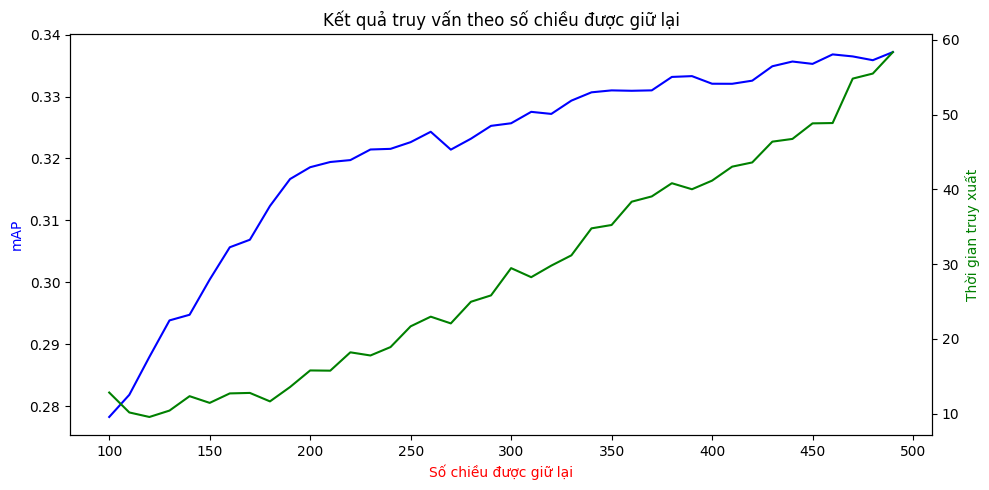

In [ ]:
# Adding a Y-Axis Label to the Secondary Y-Axis in Matplotlib
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt

# creating data for plot
# data arrangement between 0 and 50
# with the difference of 2
# x-axis
x = k

# y-axis values
y1 = map

# secondary y-axis values
y2 = running_time

# plotting figures by creating axes object
# using subplots() function
fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Kết quả truy vấn theo số chiều được giữ lại')

# using the twinx() for creating another
# axes object for secondary y-Axis
ax2 = ax.twinx()
ax.plot(x, y1, color = 'b')
ax2.plot(x, y2, color = 'g')

# giving labels to the axises
ax.set_xlabel('Số chiều được giữ lại', color = 'r')
ax.set_ylabel('mAP', color = 'b')

# secondary y-axis label
ax2.set_ylabel('Thời gian truy xuất', color = 'g')

# defining display layout
plt.tight_layout()

# show plot
plt.show()